In [1]:
import numpy as np
import scipy.io as sio
import numpy.matlib as npm
from scipy import signal
import pandas as pd
from numpy import linalg as LA
from scipy import linalg
import ipywidgets as widgets
from IPython.display import display
from scipy.signal import argrelextrema
from pynq import Overlay
from pynq import allocate

In [2]:
nop=200
dim_r = 1024
Nu_elements = 32 # Variable Number of Antenna
dim_c = Nu_elements
angles = 181
buffer_size = 2*dim_r*dim_c 
y_buffer_size = 2*angles*dim_r
angle_prec=1

In [3]:
class radar1:
    def __init__(self):
        self.fc = 60*(10**9)
        self.fs = 1.76*(10**9)
        self.L = 512
        self.PRI = 2*(10**-6)
        self.c = 3*(10**8)
        self.ts = 1/self.fs
        self.PTM_len = nop
        self.Lambda = self.c/self.fc
        self.dfd = 121
        self.im_fdmax = 12*(10**3)
        self.im_fdmin = -12*(10**3)
        
class target:
    def __init__(self, range_t, doppler_velocity, rcs_amp):
        self.range = range_t
        self.doppler_velocity = doppler_velocity
        self.rcs_amp = rcs_amp
        self.n_bodypart = 1

class antenna:
    def __init__(self, Lambda, Nelements, DOA):
        self.d_m = Lambda * 0.5
        self.Nelements = Nelements
        self.spacing = np.arange(0, (self.Nelements) * self.d_m, self.d_m)
        self.DOA = DOA # Angle for azimuth

def get_received_signal(target, radar1, xmat1, fs, fc, antenna, n_frame):
    Mvec = radar1.PRI * np.arange(0,radar1.PTM_len)
    Marray = npm.repmat(Mvec, radar1.L, 1)
    radar1.ptx = 40
    radar1.gt = 0
    radar1.gr = 0
    rxmat = np.zeros((2*radar1.L, radar1.PTM_len), dtype=np.complex128)
    rxmat_temp = np.zeros((2*radar1.L-1, radar1.PTM_len), dtype=np.complex128)
    range_to_delay_symbols = np.floor(((2*target.range)/radar1.c)/radar1.ts)
    delay_zero = np.zeros((int(range_to_delay_symbols) - 1, int(radar1.PTM_len)))
    suffix_zero = np.zeros((int(radar1.L - range_to_delay_symbols), int(radar1.PTM_len)))
    
    # Range and doppler delay
    radar1.ptx_linear = (10**(radar1.ptx//10))*0.001
    radar1.gt_linear = (10**(radar1.gt//10))
    radar1.gr_linear = (10**(radar1.gr//10))
    radar1.radar_coeff=(np.sqrt(radar1.ptx_linear*radar1.gt_linear*radar1.gr_linear)*radar1.Lambda)/np.sqrt((4*np.pi)**3)   
    for nb in range(0,target.n_bodypart):
        velvec = target.doppler_velocity
        Doppler_ele = 2*np.pi*2*velvec/radar1.Lambda
        Doppler_Delay = np.exp(1j*(Doppler_ele*Marray))   
        temp = np.multiply(xmat1,Doppler_Delay)      
        amp = np.sqrt(target.rcs_amp)/(target.range ** 2)
        rxmat_temp = (amp*radar1.radar_coeff )*np.concatenate((delay_zero, temp, suffix_zero), dtype = np.complex128)
        rxmat[0:1023,:] = rxmat_temp

    # azimuth delay
    srx = np.zeros((2 * radar1.L, radar1.PTM_len, antenna.Nelements), dtype=np.complex128)
    lambda_m = radar1.Lambda
    antenna_matrix = np.exp(1j * 2 * np.pi * (1 / lambda_m) * np.sin(np.deg2rad(antenna.DOA)) * antenna.spacing)
    for p in range(radar1.PTM_len):
            srx[:, p, :] = np.matmul(np.transpose(rxmat[:, p][np.newaxis]),antenna_matrix[np.newaxis])
    srx_volts = np.transpose(srx, (0, 2, 1))
    return srx_volts


def get_max_y(y_res):
    y_antenna = np.transpose(y_res[0])
    win_hamm_col = np.hamming(181)
    awin_col = np.sum(win_hamm_col)
    power_music = 10*np.log10(np.abs(y_antenna[511:])/awin_col) + 18.706

    index_max = np.unravel_index(np.argmax(power_music, axis=None), power_music.shape)
    max_power = power_music[index_max]
    power_music[index_max] = power_music[index_max] + 5
    return max_power, power_music

In [12]:
def write_hardware_target(array, snr_db):
    #golden_data_t1 = open("./Results_FX/P200_Vd2_snr_"+str(snr_db)+".dat", "a")
    golden_data_t1 = open("/home/xilinx/jupyter_notebooks/Aakanksha/MUSIC_Givens/DPFL/Results_FX/P200_Vd2_snr_"+str(snr_db)+".dat", "a")
    array_line = ' '.join(map(str, array))
    golden_data_t1.write(array_line + "\n")
    golden_data_t1.close()

In [5]:
radar1_in = radar1()
doppler_axis = np.arange(radar1_in.im_fdmin, radar1_in.im_fdmax + radar1_in.dfd, radar1_in.dfd)
velocity_axis = doppler_axis * radar1_in.Lambda/2
delay_axis = np.arange(-radar1_in.L + 1, radar1_in.L)
range_axis = ((radar1_in.c * radar1_in.ts) / 2) * delay_axis
theta_axis = np.arange(-90, 91, 1)
# Load XMAT
tx = sio.loadmat("/home/xilinx/jupyter_notebooks/Aakanksha/V4/tx_freq_domain.mat")["xmat"]
xmat = np.transpose(np.transpose(tx)[:nop])
xmat1=xmat*np.squeeze(np.tile(np.exp(1j * np.pi * np.arange(4)/ 2),(1,int(xmat.shape[0] / 4)))).reshape(-1,1)
xmat_padded1 = np.zeros((1024, nop),np.complex128)
xmat_padded1[0:radar1_in.L,:] = xmat1
xmat_padded = np.zeros((Nu_elements, 1024, nop), dtype=np.complex128)
for i in range(Nu_elements):
    xmat_padded[i] = xmat_padded1
xmat_padded = np.transpose(xmat_padded, (2, 0, 1))
xmat_fft_conj_tran = np.zeros(shape=np.shape(xmat_padded), dtype=np.complex128)
for i in range(radar1_in.PTM_len):
    xmat_fft_conj_tran[i] = np.conj(np.fft.fft(xmat_padded[i]))
n_frame = 1

In [6]:
   # Adding doppler delay 
def add_doppler_delay(rxmat_fft, doppler_delay):
    return np.transpose([a*b for a,b in zip(rxmat_fft, doppler_delay)])

def select_theta(avg_pre):
    return np.arange(-90, 91, avg_pre)
    
    # Method for multiplication for Diagonal elements of matrix
def diag_mat_mul(rxmat_dd, xmat_conj):
    xmat_conj_trans = np.transpose(xmat_conj)
    diag_res2 = np.sum(np.multiply(rxmat_dd, xmat_conj_trans), axis = 1)
    return diag_res2
    
def dbf(rxmat_fft, azi_delay):
    rxmat_dd=np.transpose([a*b for a,b in zip(rxmat_fft, azi_delay)])
    diag_res2_sum=np.sum(rxmat_dd,axis=1)
    return diag_res2_sum
    
def matchedfiltering_angle_v4(rxmat_fft, xmat_fft_conj_tran,k,r_in,IDFT,avg_pre=1):
    if(r_in>=1024):
        r_in=1023
    theta = select_theta(avg_pre)
    y = np.zeros(shape=(radar1_in.PTM_len-1,), dtype=np.complex128)
    temp = np.zeros(shape=(1, 2 * radar1_in.L), dtype=np.complex128)
    for i in range(radar1_in.PTM_len-1):
        theta_k = (2 * np.pi * np.sin(np.pi * theta[k] / 180)) / radar1_in.Lambda
        azi_delay = np.exp(-1j * theta_k * antenna_param.spacing)
        out=dbf(rxmat_fft[i], azi_delay)
        out1=np.multiply(out,xmat_fft_conj_tran[i+1])
        y[i]=np.matmul(IDFT[r_in,:][np.newaxis],np.transpose(out1[np.newaxis]))/1024 
    return y

def matchedfiltering2D(total_srx_noise, xmat_fft_conj_tran, avg_pre=1):
    rxmat_fft = np.zeros(shape=np.shape(total_srx_noise), dtype=np.complex128)
    rxmat_fft = np.fft.fft(total_srx_noise)

    theta = select_theta(avg_pre)
    y = np.zeros(shape=( len(theta), 2 * radar1_in.L), dtype=np.complex128)
    for k in range(len(theta)):
        theta_k = (2 * np.pi * np.sin(np.pi * theta[k] / 180)) / radar1_in.Lambda
        azi_delay = np.exp(-1j * theta_k * antenna_param.spacing)
        out=dbf(rxmat_fft, azi_delay)
        out1=np.multiply(out,xmat_fft_conj_tran)
        y[k][:] = np.fft.ifftshift(np.fft.ifft(out1))
    return y, theta

In [7]:
def get_points_2d(N, Rmax):
    D = 2
    x = np.random.randn(N, D)
    Rmin = 1
    Rad = Rmax
    
    y = np.zeros((N, D))
    r = np.zeros(N)
    
    for n in range(N):
        dr = np.linalg.norm(x[n, :])
        U = np.random.random() ** (1 / D)
        y[n, :] = U * Rad * x[n, :] / dr
        r[n] = np.linalg.norm(y[n, :])
        
        if r[n] < Rmin:
            y[n, :] = np.full(D, np.finfo(float).tiny)
    
    x_coordinate = y[:, 0]
    y_coordinate = y[:, 1]
    
    return x_coordinate, y_coordinate

In [8]:
# Single Target SNR Performance
Nu_elements = 32 # Variable Number of Antenna
np.random.seed(1)
radar_pos = np.array([0, 0])
snr_db = 10
N = 200
Rmax = 40
x_coordinate, y_coordinate = get_points_2d(N, Rmax)

range1 = np.round(np.sqrt((radar_pos[0] - x_coordinate) ** 2 + (radar_pos[1] - y_coordinate) ** 2))
theta1 = np.round(np.rad2deg(np.arctan2(y_coordinate, x_coordinate)))
range1[range1 == 0] = 1
x_coordinate, y_coordinate = get_points_2d(N, Rmax)
theta1[(np.where(np.logical_and(theta1>=90, theta1<=180)))]=theta1[(np.where(np.logical_and(theta1>=90, theta1<=180)))]-180
theta1[(np.where(np.logical_and(theta1>=-180, theta1<=-90)))]=theta1[(np.where(np.logical_and(theta1>=-180, theta1<=-90)))]+180
vel1 = np.random.randint(-25, 23, size=N)
rcs1 = np.random.exponential(10, size=N)
vel2 = vel1 + 4 #### velocity difference for super-resolution
rcs2 = np.random.exponential(10, size=N)
theta1[theta1 > 85] = 85
theta1[theta1 < -85] = -85
rcs1[rcs1 == 0] = 1
rcs2[rcs2 == 0] = 1
r = np.transpose(np.vstack((range1)))
r1=range1
o1=theta1
v1=vel1
v2=vel2
sigma1=rcs1
sigma2=rcs2

In [9]:
ol = Overlay("music.bit")
#ol = Overlay("MUSIC_FX_Givens.bit")
#ol = Overlay("/home/xilinx/jupyter_notebooks/AnkitKumarPal/SuperResolution/MUSIC/design_P200.bit")
data_channel = ol.axi_dma_0

# Function to find peaks in spectrum
def findPeaks(arr):
    maxima_indices = argrelextrema(arr, np.greater)
    local_maxima = list(zip(maxima_indices[0], arr[maxima_indices]))
    threshold = 0.50 * np.min(arr)
    local_maxima = [tup for tup in local_maxima if tup[1] >= threshold]
    if len(local_maxima)==1:
        local_maxima.append(local_maxima[0])
    sorted_maxima = sorted(local_maxima, key=lambda x: x[1], reverse=True)
    top_two_indices = [index for index, value in sorted_maxima[:2]]
    return np.array(top_two_indices)
    
# Function to perfrom Autocorrelation
def autocorrelation_func(rec_sig):
    conj_sig = np.conj(rec_sig)
    autocorrelation_matrix = []
    for i in range(len(conj_sig)):
        dat1 = np.conj(conj_sig[i]) * rec_sig
        autocorrelation_matrix.append(dat1)
    return np.array(autocorrelation_matrix)
    
def subspace_gen(doppler_axis,N):
    subspace = np.zeros((1, N), dtype=np.complex128)
    for jj in range(N):
        subspace[0, jj] = np.exp(-1j*doppler_axis*jj)
    return subspace
        
# Function to generate rotation matrix
def givensrotation(a, b):
    z = a*a + b*b
    r = np.sqrt(z.real**2 + z.imag**2)
    theta = np.arctan2(z.imag, z.real)
    hypo = np.sqrt(r) * (np.cos(theta / 2) + 1j * np.sin(theta / 2))
    if hypo == 0:
        return 1, 0
    else:
        cos1 = a/ hypo
        sin1 = -b / hypo
        return cos1, sin1
    
# QR using Givens Rotation
def qr_givens(A):
    m, n = A.shape
    R = A.copy()
    Q = np.identity(m,dtype=np.complex128)
    for i in range(0, n - 1):
        for j in range(i + 1, m):
            cos, sin = givensrotation(R[i, i], R[j, i])
            R[i], R[j] = (R[i]*cos) + (R[j]*(-sin)), (R[i]*sin) + (R[j] * cos)
            Q[i], Q[j] = (Q[i]*cos) + (Q[j]*(-sin)), (Q[i]*sin) + (Q[j] * cos)
    return Q.T, R
    
# MUSIC using Given's Rotation
def music_PS(rec_signal):
    rec_signal = rec_signal.astype(np.complex128)
    N = len(rec_signal)
    l = N//2
    subarr=N+1-l
    autocorrelation_matrix = np.zeros((l, l), dtype=np.complex128)
    for i in range(subarr):
        sub1 = rec_signal[i:(l+i)]
        sub2 = autocorrelation_func(np.array(sub1))
        autocorrelation_matrix = autocorrelation_matrix+sub2
    autocorrelation_matrix = autocorrelation_matrix/subarr
    eign_vec, eign_val = qr_givens(autocorrelation_matrix)
    noise_subspace_est = np.delete(eign_vec, [0,1], axis=1)
    doppler_axis1=[-0.15079644737231,	-0.149275916527973,	-0.147755385683635,	-0.146234854839298,	-0.14471432399496,	-0.143193793150623,	-0.141673262306285,	-0.140152731461948,	-0.13863220061761,	-0.137111669773273,	-0.135591138928935,	-0.134070608084598,	-0.132550077240261,	-0.131029546395923,	-0.129509015551586,	-0.127988484707248,	-0.126467953862911,	-0.124947423018573,	-0.123426892174236,	-0.121906361329898,	-0.120385830485561,	-0.118865299641223,	-0.117344768796886,	-0.115824237952548,	-0.114303707108211,	-0.112783176263874,	-0.111262645419536,	-0.109742114575199,	-0.108221583730861,	-0.106701052886524,	-0.105180522042186,	-0.103659991197849,	-0.102139460353511,	-0.100618929509174,	-0.0990983986648364,	-0.097577867820499,	-0.0960573369761615,	-0.0945368061318241,	-0.0930162752874866,	-0.0914957444431491,	-0.0899752135988117,	-0.0884546827544742,	-0.0869341519101368,	-0.0854136210657993,	-0.0838930902214618,	-0.0823725593771244,	-0.0808520285327869,	-0.0793314976884495,	-0.077810966844112,	-0.0762904359997745,	-0.0747699051554371,	-0.0732493743110996,	-0.0717288434667622,	-0.0702083126224247,	-0.0686877817780872,	-0.0671672509337498,	-0.0656467200894123,	-0.0641261892450749,	-0.0626056584007374,	-0.0610851275563999,	-0.0595645967120625,	-0.058044065867725,	-0.0565235350233876,	-0.0550030041790501,	-0.0534824733347126,	-0.0519619424903752,	-0.0504414116460377,	-0.0489208808017003,	-0.0474003499573628,	-0.0458798191130253,	-0.0443592882686879,	-0.0428387574243504,	-0.041318226580013,	-0.0397976957356755,	-0.038277164891338,	-0.0367566340470006,	-0.0352361032026631,	-0.0337155723583257,	-0.0321950415139882,	-0.0306745106696507,	-0.0291539798253133,	-0.0276334489809758,	-0.0261129181366384,	-0.0245923872923009,	-0.0230718564479634,	-0.021551325603626,	-0.0200307947592885,	-0.0185102639149511,	-0.0169897330706136,	-0.0154692022262761,	-0.0139486713819387,	-0.0124281405376012,	-0.0109076096932638,	-0.0093870788489263,	-0.00786654800458884,	-0.00634601716025138,	-0.00482548631591392,	-0.00330495547157646,	-0.001784424627239,	-0.000263893782901543,	0.00125663706143592,	0.00277716790577338,	0.00429769875011084,	0.0058182295944483,	0.00733876043878576,	0.00885929128312322,	0.0103798221274607,	0.0119003529717981,	0.0134208838161356,	0.0149414146604731,	0.0164619455048105,	0.017982476349148,	0.0195030071934854,	0.0210235380378229,	0.0225440688821604,	0.0240645997264978,	0.0255851305708353,	0.0271056614151727,	0.0286261922595102,	0.0301467231038477,	0.0316672539481851,	0.0331877847925226,	0.03470831563686,	0.0362288464811975,	0.037749377325535,	0.0392699081698724,	0.0407904390142099,	0.0423109698585473,	0.0438315007028848,	0.0453520315472223,	0.0468725623915597,	0.0483930932358972,	0.0499136240802346,	0.0514341549245721,	0.0529546857689096,	0.054475216613247,	0.0559957474575845,	0.0575162783019219,	0.0590368091462594,	0.0605573399905969,	0.0620778708349343,	0.0635984016792718,	0.0651189325236092,	0.0666394633679467,	0.0681599942122841,	0.0696805250566216,	0.0712010559009591,	0.0727215867452965,	0.074242117589634,	0.0757626484339714,	0.0772831792783089,	0.0788037101226464,	0.0803242409669838,	0.0818447718113213,	0.0833653026556587,	0.0848858334999962,	0.0864063643443337,	0.0879268951886711,	0.0894474260330086,	0.0909679568773461,	0.0924884877216835,	0.094009018566021,	0.0955295494103584,	0.0970500802546959,	0.0985706110990334,	0.100091141943371,	0.101611672787708,	0.103132203632046,	0.104652734476383,	0.106173265320721,	0.107693796165058,	0.109214327009396,	0.110734857853733,	0.11225538869807,	0.113775919542408,	0.115296450386745,	0.116816981231083,	0.11833751207542,	0.119858042919758,	0.121378573764095,	0.122899104608433,	0.12441963545277,	0.125940166297108,	0.127460697141445,	0.128981227985783,	0.13050175883012,	0.132022289674457,	0.133542820518795,	0.135063351363132,	0.13658388220747,	0.138104413051807,	0.139624943896145,	0.141145474740482,	0.14266600558482,	0.144186536429157,	0.145707067273495,	0.147227598117832,	0.14874812896217,	0.150268659806507,	0.151789190650844]
    p_music = []
    for i in range(len(doppler_axis)):
        subspace = subspace_gen(doppler_axis1[i],l)
        ss1_nn1 = np.matmul(subspace, noise_subspace_est)
        peak1 = np.sum(ss1_nn1.real**2) + np.sum(ss1_nn1.imag**2)
        p_music.append(peak1)
    #print("PS output")
    t=np.min(p_music)/p_music
    #for i in range(len(t)):
    #    print(t[i],",")
    p_music = np.flip(np.array(p_music))
    p_music = 10*np.log10(np.min(p_music)/p_music)
    A1 = findPeaks(p_music)
    if len(A1) == 0:
        velx1 = [30.0, 30.0]
    else:
        velocity_axis = np.linspace(-30,30,200)
        velx1 = velocity_axis[A1].tolist()
        velx1.sort(reverse=True)
    return velx1[0], velx1[1], t

# MUSIC using QR Library
def music_PS_QR(rec_signal):
    rec_signal = rec_signal.astype(np.complex64)
    N = len(rec_signal)
    l = N//2
    subarr=N+1-l
    autocorrelation_matrix = np.zeros((l, l), dtype=np.complex64)
    for i in range(subarr):
        sub1 = rec_signal[i:(l+i)]
        sub2 = autocorrelation_func(np.array(sub1))
        autocorrelation_matrix = autocorrelation_matrix+sub2
    autocorrelation_matrix = autocorrelation_matrix/subarr
    eign_vec, eign_val = np.linalg.qr(autocorrelation_matrix,mode='complete')
    noise_subspace_est = np.delete(eign_vec, [0,1], axis=1)
    print(sub1.dtype,sub2.dtype,autocorrelation_matrix.dtype,noise_subspace_est.dtype,eign_vec.dtype,eign_val.dtype,noise_subspace_est.shape )
    doppler_axis1=[-0.15079644737231,	-0.149275916527973,	-0.147755385683635,	-0.146234854839298,	-0.14471432399496,	-0.143193793150623,	-0.141673262306285,	-0.140152731461948,	-0.13863220061761,	-0.137111669773273,	-0.135591138928935,	-0.134070608084598,	-0.132550077240261,	-0.131029546395923,	-0.129509015551586,	-0.127988484707248,	-0.126467953862911,	-0.124947423018573,	-0.123426892174236,	-0.121906361329898,	-0.120385830485561,	-0.118865299641223,	-0.117344768796886,	-0.115824237952548,	-0.114303707108211,	-0.112783176263874,	-0.111262645419536,	-0.109742114575199,	-0.108221583730861,	-0.106701052886524,	-0.105180522042186,	-0.103659991197849,	-0.102139460353511,	-0.100618929509174,	-0.0990983986648364,	-0.097577867820499,	-0.0960573369761615,	-0.0945368061318241,	-0.0930162752874866,	-0.0914957444431491,	-0.0899752135988117,	-0.0884546827544742,	-0.0869341519101368,	-0.0854136210657993,	-0.0838930902214618,	-0.0823725593771244,	-0.0808520285327869,	-0.0793314976884495,	-0.077810966844112,	-0.0762904359997745,	-0.0747699051554371,	-0.0732493743110996,	-0.0717288434667622,	-0.0702083126224247,	-0.0686877817780872,	-0.0671672509337498,	-0.0656467200894123,	-0.0641261892450749,	-0.0626056584007374,	-0.0610851275563999,	-0.0595645967120625,	-0.058044065867725,	-0.0565235350233876,	-0.0550030041790501,	-0.0534824733347126,	-0.0519619424903752,	-0.0504414116460377,	-0.0489208808017003,	-0.0474003499573628,	-0.0458798191130253,	-0.0443592882686879,	-0.0428387574243504,	-0.041318226580013,	-0.0397976957356755,	-0.038277164891338,	-0.0367566340470006,	-0.0352361032026631,	-0.0337155723583257,	-0.0321950415139882,	-0.0306745106696507,	-0.0291539798253133,	-0.0276334489809758,	-0.0261129181366384,	-0.0245923872923009,	-0.0230718564479634,	-0.021551325603626,	-0.0200307947592885,	-0.0185102639149511,	-0.0169897330706136,	-0.0154692022262761,	-0.0139486713819387,	-0.0124281405376012,	-0.0109076096932638,	-0.0093870788489263,	-0.00786654800458884,	-0.00634601716025138,	-0.00482548631591392,	-0.00330495547157646,	-0.001784424627239,	-0.000263893782901543,	0.00125663706143592,	0.00277716790577338,	0.00429769875011084,	0.0058182295944483,	0.00733876043878576,	0.00885929128312322,	0.0103798221274607,	0.0119003529717981,	0.0134208838161356,	0.0149414146604731,	0.0164619455048105,	0.017982476349148,	0.0195030071934854,	0.0210235380378229,	0.0225440688821604,	0.0240645997264978,	0.0255851305708353,	0.0271056614151727,	0.0286261922595102,	0.0301467231038477,	0.0316672539481851,	0.0331877847925226,	0.03470831563686,	0.0362288464811975,	0.037749377325535,	0.0392699081698724,	0.0407904390142099,	0.0423109698585473,	0.0438315007028848,	0.0453520315472223,	0.0468725623915597,	0.0483930932358972,	0.0499136240802346,	0.0514341549245721,	0.0529546857689096,	0.054475216613247,	0.0559957474575845,	0.0575162783019219,	0.0590368091462594,	0.0605573399905969,	0.0620778708349343,	0.0635984016792718,	0.0651189325236092,	0.0666394633679467,	0.0681599942122841,	0.0696805250566216,	0.0712010559009591,	0.0727215867452965,	0.074242117589634,	0.0757626484339714,	0.0772831792783089,	0.0788037101226464,	0.0803242409669838,	0.0818447718113213,	0.0833653026556587,	0.0848858334999962,	0.0864063643443337,	0.0879268951886711,	0.0894474260330086,	0.0909679568773461,	0.0924884877216835,	0.094009018566021,	0.0955295494103584,	0.0970500802546959,	0.0985706110990334,	0.100091141943371,	0.101611672787708,	0.103132203632046,	0.104652734476383,	0.106173265320721,	0.107693796165058,	0.109214327009396,	0.110734857853733,	0.11225538869807,	0.113775919542408,	0.115296450386745,	0.116816981231083,	0.11833751207542,	0.119858042919758,	0.121378573764095,	0.122899104608433,	0.12441963545277,	0.125940166297108,	0.127460697141445,	0.128981227985783,	0.13050175883012,	0.132022289674457,	0.133542820518795,	0.135063351363132,	0.13658388220747,	0.138104413051807,	0.139624943896145,	0.141145474740482,	0.14266600558482,	0.144186536429157,	0.145707067273495,	0.147227598117832,	0.14874812896217,	0.150268659806507,	0.151789190650844]
    p_music = []
    for i in range(len(doppler_axis)):
        subspace = subspace_gen(doppler_axis1[i],l)
        ss1_nn1 = np.matmul(subspace, noise_subspace_est)
        peak1 = np.sum(ss1_nn1.real**2) + np.sum(ss1_nn1.imag**2)
        p_music.append(peak1)
    #print("PS output")
    t=np.min(p_music)/p_music
    #for i in range(len(t)):
    #    print(t[i],",")
    p_music = np.array(p_music)
    p_music = 10*np.log10(np.min(p_music)/p_music)
    A1 = findPeaks(p_music)
    if len(A1) == 0:
        velx1 = [30.0, 30.0]
    else:
        velocity_axis = np.linspace(-30,30,200)
        velx1 = velocity_axis[A1].tolist()
        velx1.sort(reverse=True)
    return velx1[0], velx1[1], t


def music1(rec_signal1):
    input_buffer = allocate((nop,),np.cdouble)
    output_buffer = allocate((200,),np.single)
    
    send_channel = data_channel.sendchannel
    recv_channel = data_channel.recvchannel
    
    np.copyto(input_buffer,rec_signal1)

    send_channel.transfer(input_buffer)
    recv_channel.transfer(output_buffer)
    send_channel.wait()
    recv_channel.wait()
    #print("PL output")
    #print(output_buffer)
    peaks1 = 10*np.log10(np.flip(np.abs(output_buffer)))
    return peaks1,output_buffer


def music_PL(rec_signal1):
    p_music,ob = music1(rec_signal1)
    
    while(np.isnan(p_music[0])):
        rec_signal1 = rec_signal1 * 3.1622776602/2
        p_music,ob = music1(rec_signal1)
        print("nan detected")
        
    A1 = findPeaks(np.flip(p_music))
    if len(A1) == 0:
        velx1 = [30.0, 30.0]
    else:
        velocity_axis = np.linspace(-30,30,200)
        velx1 = velocity_axis[A1].tolist()
        velx1.sort(reverse=True)
        
    return velx1[0], velx1[1], ob

def MUSIC_F(rec_signal1):
    #print("INPUT")
    #print(np.real(rec_signal1))
    #print(np.imag(rec_signal1))
    vx1, vx2, p_music_PS = music_PS(rec_signal1)
    vx3, vx4, p_music_PL = music_PL(rec_signal1)
    #vx3, vx4, p_music_PL = music_PS_QR(rec_signal1)
    return vx1, vx2, vx3, vx4, p_music_PL, p_music_PS 

In [13]:
p_music_PL=np.zeros((12,200,200))
p_music_PS=np.zeros((12,200,200))
music_input=np.zeros((12,200,nop),'complex128')
s=0
for j in range(1):
    N=5
    snr_db = 10
    signal_power = np.zeros(N)
    srx_volts = np.zeros((N, radar1_in.PTM_len, Nu_elements, 2 * radar1_in.L), dtype=np.complex128)
    srx_noise = np.zeros((N, radar1_in.PTM_len, Nu_elements, 2 * radar1_in.L), dtype=np.complex128)
    rxmat_fft = np.zeros(shape=np.shape(srx_noise[1:,:,:]), dtype=np.complex128)
    n1 = 1024
    w1 = np.exp(-1j * 2 * np.pi / n1)
    I, J = np.meshgrid(np.arange(1, n1 + 1), np.arange(1, n1 + 1))
    DFT1 = w1**((I - 1) * (J - 1))
    IDFT = np.transpose(np.conj(DFT1))
    mean_signal_power=(10*32*1*(0.005**2)*1)/(((4*np.pi)**3)*(40**4))
    print("Round: " + str(j))
    for snr_db in [-15,-10,-5,0,5,10,15,20,25,30,35,40]:
    #for snr_db in [40]:
        print("SNR:", snr_db)
        snr_linear = 10 ** (snr_db/10)
        noise_power = mean_signal_power/snr_linear
        for i in range(j*N,(j+1)*N):
            range_t=r1[i];
            velocity1=v1[i];
            velocity2=v2[i];
            rcs_amp1=sigma1[i];
            rcs_amp2=sigma2[i];
            DOA_angle=o1[i];
            t1 = target(range_t, velocity1, rcs_amp1)
            t2 = target(range_t, velocity2, rcs_amp2) 
            antenna_param = antenna(radar1_in.Lambda, Nu_elements, DOA_angle)
            rxmat_t1 = get_received_signal(t1, 
                                            radar1_in, 
                                            xmat1, 
                                            radar1_in.fs, 
                                            radar1_in.fc, 
                                            antenna_param, 
                                            n_frame)

            rxmat_t2 = get_received_signal(t2, 
                                            radar1_in, 
                                            xmat1, 
                                            radar1_in.fs, 
                                            radar1_in.fc, 
                                            antenna_param, 
                                            n_frame)
            rxmat_t12 = rxmat_t1 + rxmat_t2
            srx_volts = np.transpose(rxmat_t12, (2, 1, 0))
            noise = np.sqrt(noise_power) * (np.random.randn(srx_volts.shape[0],srx_volts.shape[1],srx_volts.shape[2]) + (1j * np.random.randn(srx_volts.shape[0],srx_volts.shape[1],srx_volts.shape[2])))
            srx_noise = srx_volts + noise
            rxmat_fft = np.fft.fft(srx_noise[1:,:,:])
            
            y_pack1 = np.zeros(shape=(radar1_in.PTM_len,), dtype=np.complex128)
            y_p1 = np.zeros(shape=(radar1_in.PTM_len-1,), dtype=np.complex128)
            
            y_res, theta = matchedfiltering2D(srx_noise[0,:,:], xmat_fft_conj_tran[0,0,:], avg_pre=angle_prec) 
            [a1, b1] = np.unravel_index(np.argmax(np.abs(y_res)), y_res.shape)
            mf_t1=y_res[a1,b1]
            if(b1<=512):
                b1_new=b1+512
            else:
                b1_new=b1-512
            y_p1 = matchedfiltering_angle_v4(rxmat_fft, xmat_fft_conj_tran[:,0,:],a1,b1_new,IDFT)
            y_pack1[1:radar1_in.PTM_len]=y_p1
            y_pack1[0]=mf_t1
            music_in1=y_pack1
            music_in = music_in1.flatten()
            music_input[s,i,:]=music_in
            vx1, vx2, vx3, vx4, p_music_PL[s,i,:], p_music_PS[s,i,:] = MUSIC_F(music_in)
            hw = np.array([velocity2,velocity1,vx1, vx2, vx3, vx4])
            write_hardware_target(hw, snr_db)
            #print(s,i)
        s=s+1
    s=0

Round: 0
SNR: -15
SNR: -10
SNR: -5
SNR: 0
SNR: 5
SNR: 10
SNR: 15
SNR: 20
SNR: 25
SNR: 30
SNR: 35
SNR: 40


In [14]:
import scipy.io as sio
sio.savemat('FX_p_music_PL.mat',{'FX_p_music_PL':p_music_PL})
sio.savemat('FX_p_music_PS.mat',{'FX_p_music_PS':p_music_PS})
sio.savemat('FX_music_input.mat',{'FX_music_input':music_input})

In [15]:
p_music_PL=sio.loadmat("/home/xilinx/jupyter_notebooks/Aakanksha/MUSIC_Givens/DPFL/FX_p_music_PL.mat")["FX_p_music_PL"]

In [16]:
p_music_PL[2,21,:]
#p_music_PS[6,3,:]
#np.imag(music_input[11,5,:])

array([1.31225586e-03, 7.00826645e-02, 1.27124786e-03, 6.42776489e-04,
       4.31060791e-04, 3.24249268e-04, 2.60353088e-04, 2.17437744e-04,
       1.86920166e-04, 1.64031982e-04, 1.46865845e-04, 1.32560730e-04,
       1.20162964e-04, 1.10626221e-04, 1.02996826e-04, 9.53674316e-05,
       8.96453857e-05, 8.39233398e-05, 7.91549683e-05, 7.53402710e-05,
       7.15255737e-05, 6.77108765e-05, 6.48498535e-05, 6.19888306e-05,
       6.00814819e-05, 5.72204590e-05, 5.53131104e-05, 5.34057617e-05,
       5.14984131e-05, 4.95910645e-05, 4.86373901e-05, 4.67300415e-05,
       4.57763672e-05, 4.38690186e-05, 4.29153442e-05, 4.19616699e-05,
       4.10079956e-05, 4.00543213e-05, 3.91006470e-05, 3.81469727e-05,
       3.71932983e-05, 3.81469727e-05, 3.91006470e-05, 4.00543213e-05,
       4.10079956e-05, 4.19616699e-05, 4.29153442e-05, 4.38690186e-05,
       4.48226929e-05, 4.57763672e-05, 4.76837158e-05, 4.86373901e-05,
       4.95910645e-05, 5.14984131e-05, 5.24520874e-05, 5.34057617e-05,
      

21


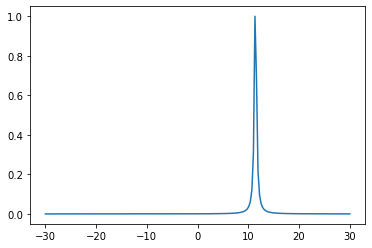

In [17]:
import matplotlib.pyplot as plt
velocity_axis = np.linspace(-30,30,200)
for i in [21]:
    print(i);
    plt.figure()
    plt.plot(velocity_axis,p_music_PL[1,i,:])
    plt.show()
    a=p_music_PL[2,i,:]
    for j in range(199):
        if(a[j]==a[j+1] and a[j]>0.005):
            print(a[j],a[j+1],velocity_axis[j],velocity_axis[j+1])
            print(p_music_PL[2,i,:])

In [19]:
A1 = findPeaks(np.flip(p_music_PL[11,43,:]))
velocity_axis = np.linspace(-30,30,200)
velx1 = velocity_axis[A1].tolist()
velx1.sort(reverse=True)
A1
#velx1

IndexError: arrays used as indices must be of integer (or boolean) type